In [1]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

/home/zyuanjue/repos/active-learning/mnistvae


In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions



BATCH_SIZE = 16

2023-12-23 04:57:50.076252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 04:57:50.076293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 04:57:50.078003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 04:57:50.882840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [15]:
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

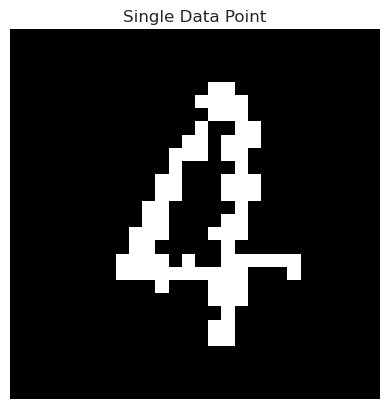

In [5]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [16]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)


step/epoch: 500/0	 distortion: 0.195	 loss: 0.197	 rate: 0.002
step/epoch: 1000/0	 distortion: 0.146	 loss: 0.150	 rate: 0.004
step/epoch: 1500/0	 distortion: 0.171	 loss: 0.175	 rate: 0.005
step/epoch: 2000/0	 distortion: 0.136	 loss: 0.142	 rate: 0.005
step/epoch: 2500/0	 distortion: 0.123	 loss: 0.128	 rate: 0.005
step/epoch: 3000/0	 distortion: 0.139	 loss: 0.144	 rate: 0.005
step/epoch: 3500/0	 distortion: 0.138	 loss: 0.144	 rate: 0.006
step/epoch: 4000/1	 distortion: 0.129	 loss: 0.136	 rate: 0.007
step/epoch: 4500/1	 distortion: 0.131	 loss: 0.137	 rate: 0.006
step/epoch: 5000/1	 distortion: 0.140	 loss: 0.146	 rate: 0.006
step/epoch: 5500/1	 distortion: 0.142	 loss: 0.149	 rate: 0.007
step/epoch: 6000/1	 distortion: 0.124	 loss: 0.131	 rate: 0.006
step/epoch: 6500/1	 distortion: 0.167	 loss: 0.173	 rate: 0.006
step/epoch: 7000/1	 distortion: 0.134	 loss: 0.140	 rate: 0.006
step/epoch: 7500/1	 distortion: 0.119	 loss: 0.125	 rate: 0.006
step/epoch: 8000/2	 distortion: 0.131	 lo

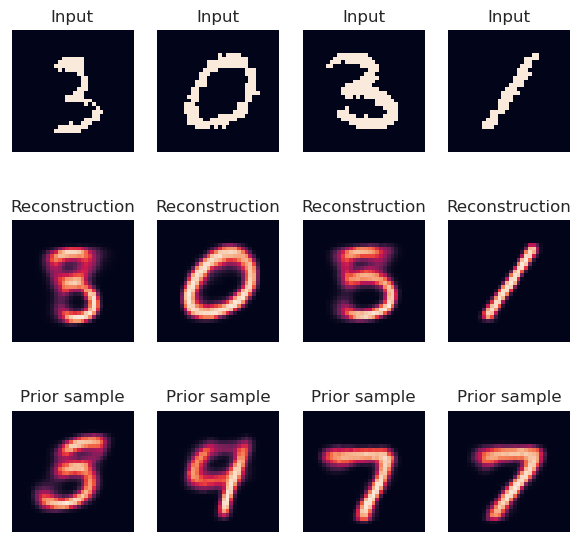

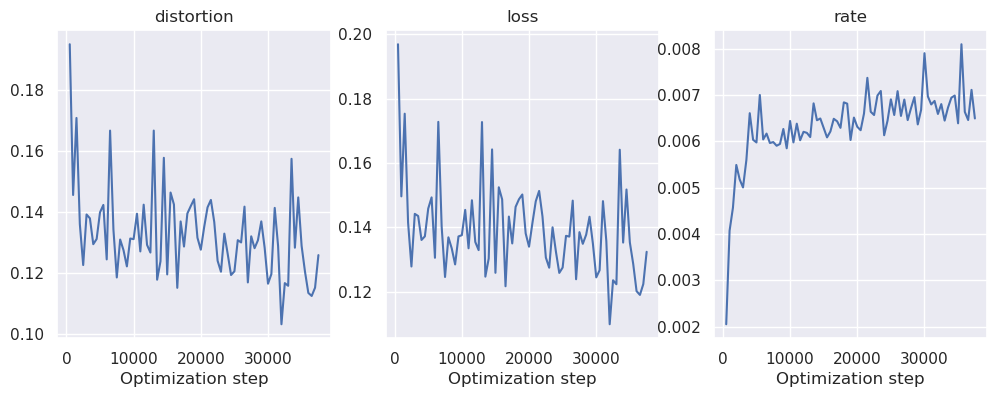

In [17]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)



@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state

MAX_EPOCHS = 10
steps_per_epoch = 60000 // batch_size 

step = 0  
train_metrics = None

for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch = jnp.squeeze(batch)
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

            log_str = f"step/epoch: {step}/{epoch}"
            for k, v in aux.items():
                log_str += f"\t {k}: {v:.3f}"
            print(log_str)

        # Check if the epoch is completed
        if step % steps_per_epoch == 0:
            break  # End the current epoch

# Reset step for the next epoch or other post-epoch processing


visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

In [18]:
eqx.tree_serialise_leaves("equinoxvae.eqx", model)